In [108]:
#import Libraries
import math 
import pandas_datareader as web
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
plt.style.use('fivethirtyeight')
import datetime
import pandas as pd
import sqlalchemy as sa


In [109]:

#connection_string_Housing = "mssql+pyodbc:///?odbc_connect=DRIVER={ODBC Driver 18 for SQL Server};SERVER=KALLESPC;DATABASE=Housing;Encrypt=NO;Trusted_Connection=yes"
#connection_string_GDP_GROWTH = "mssql+pyodbc:///?odbc_connect=DRIVER={ODBC Driver 18 for SQL Server};SERVER=KALLESPC;DATABASE=GDP_GROWTH_1998_2024_STATE;Encrypt=NO;Trusted_Connection=yes"
#engine = sa.create_engine(connection_string_Housing)

import sqlalchemy as sa
import pandas as pd
import urllib

params = urllib.parse.quote_plus(
    "DRIVER={ODBC Driver 18 for SQL Server};"
    "SERVER=localhost;"
    "DATABASE=Housing;"
    "UID=SA;"
    "PWD=SuperK_0606$;"
    "Encrypt=no;"
    "TrustServerCertificate=yes"
)

connection_string_Housing = f"mssql+pyodbc:///?odbc_connect={params}"

engine = sa.create_engine(connection_string_Housing)

# Read table into DataFrame
Housing_prices_df = pd.read_sql('SELECT * from hpi_po_monthly_hist', engine)
print(Housing_prices_df.head())

      column1     column2     column3     column4     column5     column6  \
0  1991-01-01  100.000000  100.000000  100.000000  100.000000  100.000000   
1  1991-02-01  100.870003  100.860001  100.889999  100.500000  100.040001   
2  1991-03-01  101.320000  100.900002  100.800003  100.410004  100.059998   
3  1991-04-01  101.720001  100.970001  100.739998  100.459999   99.599998   
4  1991-05-01  102.320000  101.300003  101.040001  100.629997   99.720001   

      column7     column8     column9    column10  ...    column12  \
0  100.000000  100.000000  100.000000  100.000000  ...  100.000000   
1  100.089996   98.370003   98.790001  101.650002  ...  100.180000   
2   99.750000  100.349998  100.699997  101.430000  ...   99.959999   
3   99.250000  100.269997  100.330002  100.930000  ...  100.139999   
4   99.199997  100.739998  100.550003   99.739998  ...  100.339996   

     column13    column14    column15    column16    column17    column18  \
0  100.000000  100.000000  100.000000  

/home/kalle/kdatascience/lib/python3.12/site-packages/pandas/io/sql.py:1648: SAWarning: Unrecognized server version info '17.0.800.3'.  Some SQL Server features may not function properly.
  con = self.exit_stack.enter_context(con.connect())


In [110]:
print(Housing_prices_df.shape)
Housing_prices_df.sort_values(by = 'column1', inplace=True)

(411, 21)


Coefficients: [[0.44480533]
 [0.44091612]
 [0.5825031 ]
 [0.57675907]
 [0.58829431]
 [0.5834893 ]
 [1.01928918]
 [1.01250629]
 [0.65837842]
 [0.65154772]
 [0.83415606]
 [0.83058427]
 [0.71651913]
 [0.70893548]
 [0.61140828]
 [0.60545603]
 [0.70059326]
 [0.69624621]
 [0.66721901]
 [0.66105093]]
Intercept: [93.02325346 92.42418989 76.55924859 76.53568102 70.7870872  70.40561845
 53.67965868 54.01042009 67.87071962 67.90573396 48.71372582 48.68966569
 62.75401643 62.7294908  82.25993961 81.96526105 62.60750499 62.39595026
 68.68007874 68.56149395]


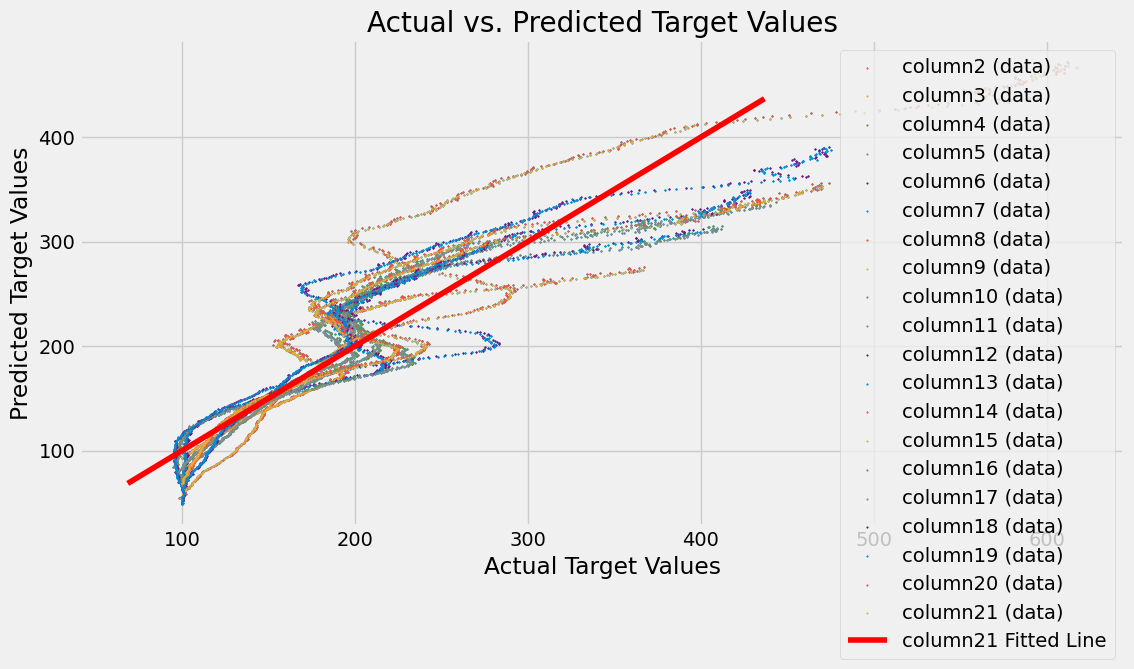

In [111]:
Housing_prices_df['column1'] = np.arange(len(Housing_prices_df.index))
x = Housing_prices_df[['column1']]  # First column (as a DataFrame)
y = Housing_prices_df.iloc[:, 1:]  
model = LinearRegression()
model.fit(x,y)
print(f"Coefficients: {model.coef_}")
print(f"Intercept: {model.intercept_}")
predictions = model.predict(x)
plt.figure(figsize=(12, 6))
plt.scatter(y, predictions, s=1)
plt.xlabel("Actual Target Values")
plt.ylabel("Predicted Target Values")
plt.title("Actual vs. Predicted Target Values")
for i, col in enumerate(y.columns):
    plt.scatter(y[col], predictions[:, i], s=1, label=f'{col} (data)')  # Smaller dots (s=10)
min_val = min(y[col].min(), predictions[:, i].min())
max_val = max(y[col].max(), predictions[:, i].max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle='-', color='red', label=f'{col} Fitted Line')
plt.legend()
plt.show()

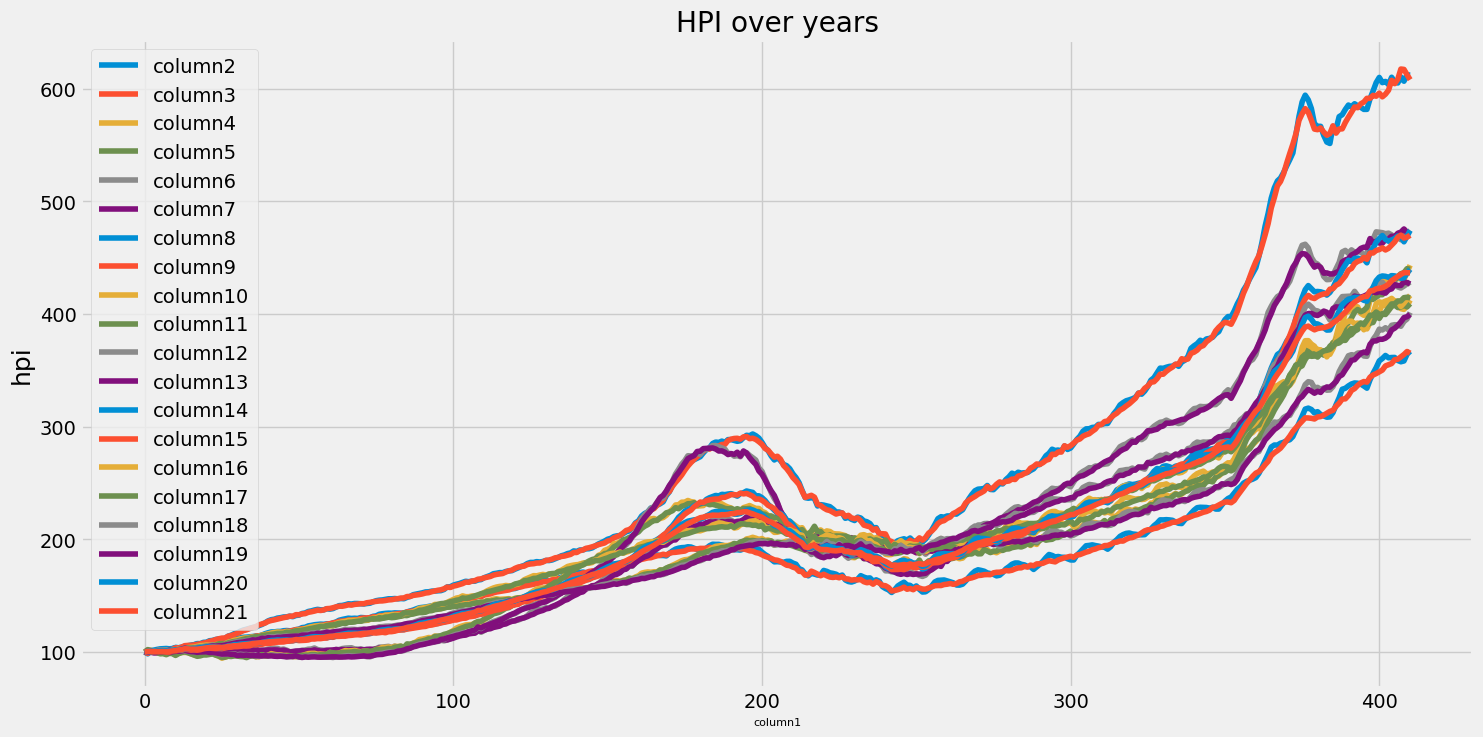

In [112]:
#Visualize the data 
#Housing_prices_df['Year'] = pd.to_datetime(Housing_prices_df['Year'])
Housing_prices_df.set_index('column1',inplace=True)
Housing_prices_df.sort_index(inplace=True)
plt.figure(figsize=(16,8))
plt.title('HPI over years')
#plt.plot(Housing_prices_df['Year'],Housing_prices_df['avg_hpi'])
plt.xlabel('Date', fontsize=8)
plt.ylabel('hpi', fontsize=18)
Housing_prices_df.plot(ax=plt.gca())
plt.show()

In [113]:
#create a new dataframe with only the "" column
hpivalues = Housing_prices_df
#Convert the data frame to a numpy array
hpivalues = hpivalues.to_numpy().reshape((-1,20))
print(hpivalues.shape)
#get the number of rows to train the model on 
Training_data_len = math.ceil(len(hpivalues)*.83)


(411, 20)


In [114]:
#Good practice to Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
#create variable to hold scaled data
#print(hpivalues.shape)
scaled_data = scaler.fit_transform(hpivalues)#<----computes minimum and maximum values that are used for scaling and transforms data based on those values

scaled_data.shape

(411, 20)

In [115]:
#Create the training data set
#Create the Scaled training data set
train_data = scaled_data[0:Training_data_len , :]
#Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, :])
    y_train.append(train_data[i,:])
    if i<=60:
        print(x_train)
        print(y_train)
#the first 229 values(x_train) are the values that will train the data to predict the 230th value(y_train)

[array([[0.        , 0.        , 0.        , ..., 0.00088189, 0.        ,
        0.        ],
       [0.00325832, 0.00322424, 0.00284909, ..., 0.        , 0.00105957,
        0.00115796],
       [0.00494363, 0.0033742 , 0.00256099, ..., 0.00261526, 0.00197197,
        0.00136579],
       ...,
       [0.09269315, 0.08885388, 0.07401243, ..., 0.05035883, 0.03970449,
        0.03800476],
       [0.09216883, 0.08956622, 0.07430053, ..., 0.05187933, 0.03985166,
        0.03862827],
       [0.0937418 , 0.09256552, 0.07487675, ..., 0.05461623, 0.04020486,
        0.04008314]])]
[array([0.09310513, 0.09421511, 0.07558102, 0.07651017, 0.00593108,
       0.00940669, 0.07724037, 0.07686376, 0.01447861, 0.01358437,
       0.00100191, 0.00149862, 0.03602064, 0.03611853, 0.07345418,
       0.07528896, 0.05293115, 0.05364311, 0.04049918, 0.04130049])]


In [116]:
#convert the x_train and y_train to numpy arrays

x_train, y_train = np.array(x_train), np.array(y_train)
print(x_train.shape)
print(y_train.shape)

(282, 60, 20)
(282, 20)


In [117]:
#Reshape the data
x_train = np.reshape(x_train,(x_train.shape[0], x_train.shape[1], 20))

print(x_train.shape)
print(y_train.shape)

(282, 60, 20)
(282, 20)


In [118]:
#Build the LSTM model
from keras.layers import Input
model = Sequential([
    Input(shape=(60, 20)),         # First layer is now Input
    LSTM(128, return_sequences=True),
    LSTM(64),
    Dense(20)
])
#model.add(LSTM(128, return_sequences= True, input_shape= (x_train.shape[1],x_train[2])))
#model.add(LSTM(64, return_sequences= False))
#model.add(Dense(20))
#model.add(Dense(20))

In [119]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [133]:
#train the model
model.fit(x_train, y_train, batch_size=10, epochs=400)

Epoch 1/400
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.0500e-04
Epoch 2/400
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.1789e-05
Epoch 3/400
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.2510e-05
Epoch 4/400
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.7987e-05
Epoch 5/400
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.6888e-05
Epoch 6/400
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.6782e-05
Epoch 7/400
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.9081e-05
Epoch 8/400
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.5679e-05
Epoch 9/400
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.7762e-05
Epoch 10/400
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.5622e-05
Epoch 11/400
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.7485e-05
Epoch 12/400
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.6002e-05
Epoch 13/400
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.5453e-05
Epoch 14/400
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.7073e-05
Epoch 15/400
29

In [134]:
#Create the testing data set
test_data = scaled_data[Training_data_len - 60: , :  ]
#Create the data sets x_test and y_test
x_test = []
y_test = scaled_data[Training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, :])

In [135]:
#Convert the data to a numpy array
x_test = np.array(x_test)

In [136]:
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],20))
x_test.shape

(69, 60, 20)

In [137]:
#Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [138]:
rmse = np.sqrt(np.mean(predictions - y_test)**2 )
rmse

np.float64(324.4069063953732)

/tmp/ipykernel_78401/992862255.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions[:,1]


ValueError: Boolean array expected for the condition, not float64

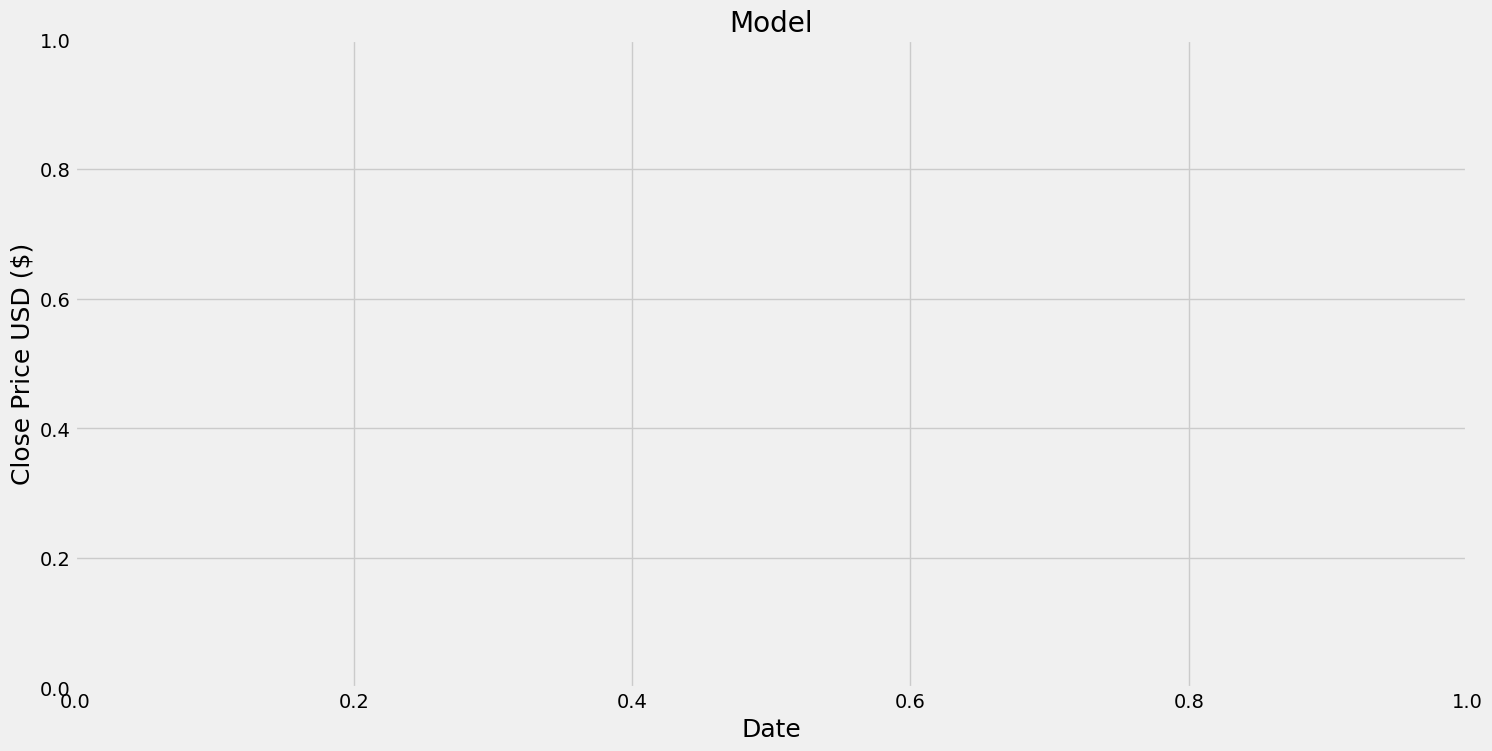

In [139]:
train = Housing_prices_df[:Training_data_len]
valid = Housing_prices_df[Training_data_len:]
valid['Predictions'] = predictions[:,1]
#visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(valid[Housing_prices_df])
plt.plot(valid[['array_hpi_values','Predictions']])
plt.legend(['Train','Val','Predictions'], loc = 'lower right')
plt.show()